This notebook implements the DANN model from https://arxiv.org/abs/1505.07818. It is inspired from https://github.com/fungtion/DANN and https://github.com/Yangyangii/DANN-pytorch/blob/master/DANN.ipynb.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

torch.cuda.empty_cache()

We can set the seed for all packages to ensure reproducibility.

In [2]:
torch.manual_seed(0)

For reference, here follows a diagram of the model from the paper:

<img src="Resources/DANN/Model diagram.png" align="center"/>

We start by implementing the feature extractor portion of the DANN, using a pre-trained VGG16.

In [3]:
class GradientReversal(torch.autograd.Function):
    """
        Gradient Reversal Layer
    """

    @staticmethod
    def forward(ctx, x, lamb):
        ctx.lamb = lamb # Save the lambda DA hyperparameter to use during the backward pass
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lamb
        return output


In [4]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

We then proceed to implement to Classifier portion of the model.

In [5]:
class Classifier(nn.Module):
    """
        Classifier
    """

    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes) # The softmax function is part of the loss for stability
        )

    def forward(self, h):
        c = self.layer(h)
        return c

Finally, we implement the discriminator.

In [6]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """

    def __init__(self, input_size=512, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes) # The sigmoid function is part of the loss for stability
        )

    def forward(self, h, lamb):
        h = GradientReversal.apply(h, lamb)
        y = self.layer(h)
        return y

We then proceed to check for the existence of a gpu to train faster.

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [8]:
F = FeatureExtractor(in_channel=3).to(DEVICE)
C = Classifier(num_classes=13).to(DEVICE)
D = Discriminator().to(DEVICE)

We can now proceed to load the datasets, starting with the source domain real-life data.

In [9]:
# Extract the file names
target_domain_path = "Real life data/Pre-processed"
source_domain_path = "Data Generation/Data Generated/Dataset PreProcessed"
num_real_examples = 200
num_generated_examples = 200



# Load the real-life data
X_real = np.empty((num_real_examples*64, 3, 130, 130))

for i in range(num_real_examples):
    X_real_life[i*64:(i+1)*64] = np.load(os.getcwd()+"/../../Real life data/Pre-processed/Images/EX_%04d.npy.npz" %
                                         i, allow_pickle=True)['arr_0']  # Load the data (compressed array so index the first one with ['arr_0'])
# Drop row 0 corresponding to the header, only extract the image (Column 1) and normalize the values
X_real = np.concatenate([np.stack(np.load(target_domain_path + "/Images/EX_%04d.npy" %
                        i, allow_pickle=True), axis=0) / 255 for i in range(num_real_examples)])
# Drop the row 0 corresponding to the header, only extract the label (Column 2)
y_real = np.concatenate([np.load(target_domain_path+"/EX_%04d.npy" %
                        i, allow_pickle=True)[1:, 2] for i in range(num_real_examples)])

# Load the generated data in a similar format
X_generated = np.concatenate([np.stack(np.load(source_domain_path + "/EX_%04d.npy" % i, allow_pickle=True)[
                             1:, 1], axis=0)[:, :, :, :3]/255 for i in range(num_generated_examples)])
y_generated = np.concatenate([np.load(source_domain_path + "/EX_%04d.npy" %
                             i, allow_pickle=True)[1:, 2] for i in range(num_generated_examples)])

# Extract the the number of examples as well as the number of features into variables
N_real = X_real.shape[0] # Number of real-life examples, equal to num_real_examples * 64 (Individual squares of the board)
N_generated = X_generated.shape[0]
N_features = X_real.shape[1] # Number of features (Same for both real and generated data)


FileNotFoundError: [Errno 2] No such file or directory: 'Real life data/Pre-processed/EX_0000.npy'

For now we are working with 50 board examples, which amounts to 50*64 = 3200 squares for each domain. As a sanity check, we can visualize the shapes of the datasets as well as a single training example from each. We choose the examples such that they both represent a white rook for clarity.

Real life data features shape: (3200, 130, 130, 3)
Real life data labels shape: (3200,)
Generated data features shape: (3200, 130, 130, 3)
Generated data labels shape: (3200,)


Text(0.5, 1.0, 'Generated data - Label: 4')

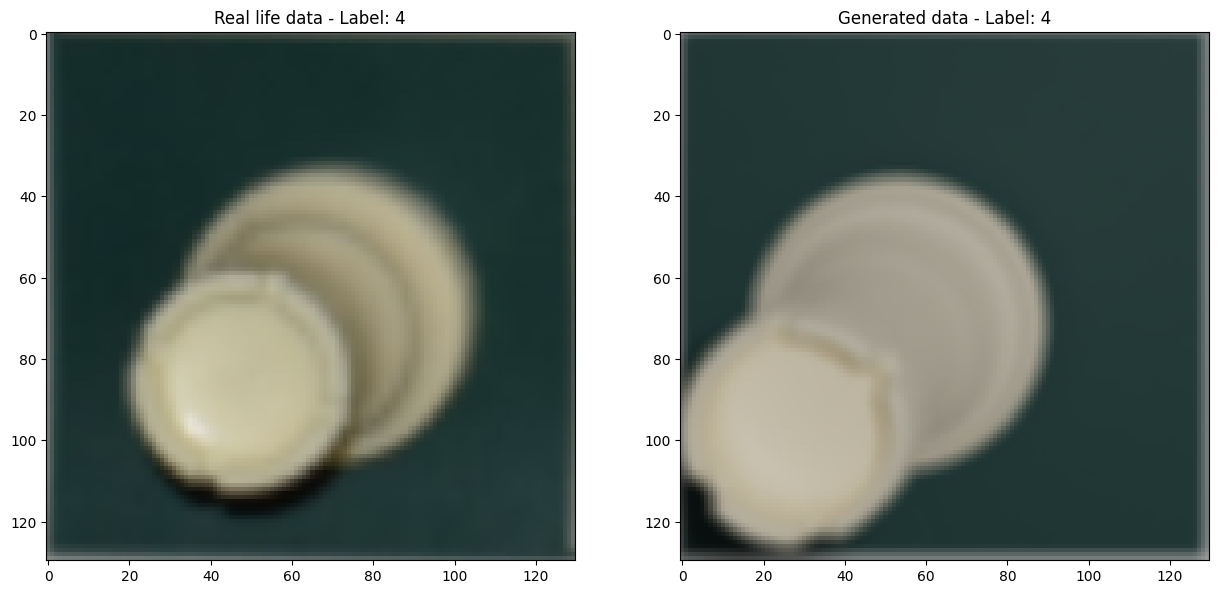

In [ ]:
print(f"Real life data features shape: {X_real.shape}")
print(f"Real life data labels shape: {y_real.shape}")
print(f"Generated data features shape: {X_generated.shape}")
print(f"Generated data labels shape: {y_generated.shape}")

plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plt.title("Real life data - Label: %d" % y_real[448])
plt.imshow(X_real[448])

plt.subplot(1, 2, 2)
plt.imshow(X_generated[0])
plt.title("Generated data - Label: %d" % y_generated[0])

In [ ]:
X_real = np.transpose(X_real, (0, 3, 1, 2))
X_generated = np.transpose(X_generated, (0, 3, 1, 2))
print(X_real.shape)
print(X_generated.shape)

(6400, 3, 130, 130)


We now perform a train/validation/test split of the dataset above. We decided on an 80/10/10 split for each dataset, which we accomplish using scikit-learn's train_test_split function.

In [ ]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42, shuffle=True)
X_real_test, X_real_val, y_real_test, y_real_val = train_test_split(X_real_test, y_real_test, test_size=0.5, random_state=42, shuffle=True)
X_generated_train, X_generated_test, y_generated_train, y_generated_test = train_test_split(X_generated, y_generated, test_size=0.2, random_state=42, shuffle=True)
X_generated_test, X_generated_val, y_generated_test, y_generated_val = train_test_split(X_generated_test, y_generated_test, test_size=0.5, random_state=42, shuffle=True)


Because the dataset looks good, we can now proceed to create a Dataset class to store the features & labels in a tidy way.

In [ ]:
class Chess_Dataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.X)


It is now useful to include a cell that controls the hyperparameters of the model so that they are all grouped in a single location.

In [ ]:
initial_learning_rate = 0.01 # Suggested by paper
gamma = 10 # Suggested by paper
alpha = 10 # Suggested by paper
beta = 0.75 # Suggested by paper
batch_size = 5
max_epoch = 50
n_domain = 1  # Train the discriminator n_critic times for every feature extractor and classifier update
n_loss = 10  # Print the loss every n_loss steps


To explain further, the learning rate is updated as follows:
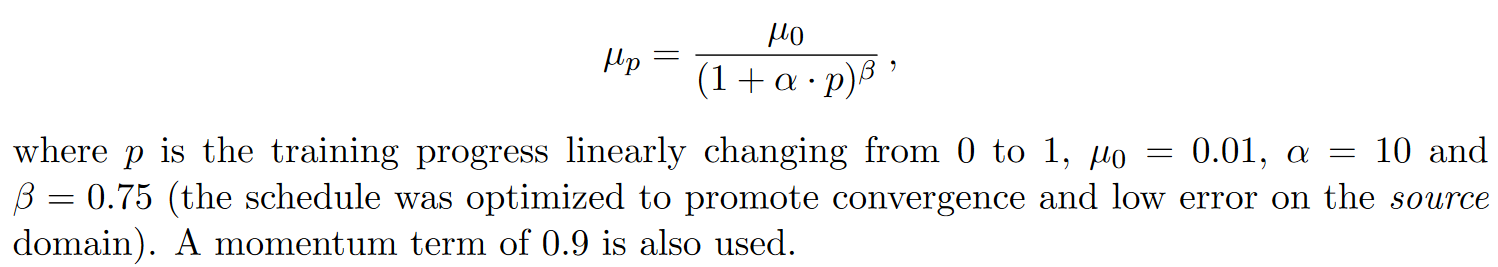

We now proceed to initialize a dataset and dataloader per training/validation/testing set.

In [ ]:
# Create the datasets and dataloaders
gen_train_dataset = Chess_Dataset(X_generated_train, y_generated_train)
gen_train_loader = DataLoader(gen_train_dataset, batch_size=batch_size, shuffle=True)

gen_val_dataset = Chess_Dataset(X_generated_val, y_generated_val)
gen_val_loader = DataLoader(gen_val_dataset, batch_size=batch_size, shuffle=True)

gen_test_dataset = Chess_Dataset(X_generated_test, y_generated_test)
gen_test_loader = DataLoader(gen_test_dataset, batch_size=batch_size, shuffle=True)

real_train_dataset = Chess_Dataset(X_real_train, y_real_train)
real_train_loader = DataLoader(real_train_dataset, batch_size=batch_size, shuffle=True)

real_val_dataset = Chess_Dataset(X_real_val, y_real_val)
real_val_loader = DataLoader(real_val_dataset, batch_size=batch_size, shuffle=True)

real_test_dataset = Chess_Dataset(X_real_test, y_real_test)
real_test_loader = DataLoader(real_test_dataset, batch_size=batch_size, shuffle=True)


We now move on to defining our loss functions for both the piece and domain classification tasks.

In [ ]:
domain_loss = nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss with sigmoid
piece_loss = nn.CrossEntropyLoss() # Includes the softmax function

We can now define the optimizers of each model. We opt for Adam since it's an industry standard.

In [ ]:
F_opt = torch.optim.SGD(F.parameters(), lr=initial_learning_rate)
C_opt = torch.optim.SGD(C.parameters(), lr=initial_learning_rate)
D_opt = torch.optim.SGD(D.parameters(), lr=initial_learning_rate)

We also define the following function that acts as a custom scheduler for the learning rate, following the advice from the paper.

In [ ]:
def adjust_optim(optimizer, new_lr):
    optimizer.param_groups[0]['lr'] = new_lr

We can now define a loop below. It is to be noted that the length of an epoch is defined by the number of real life training examples, not by the number of generated training examples, because we always try to keep our minibatches at a 50/50 split between real life and generated data.

In [ ]:
iteration = 1

# Epoch loop
for epoch in range(max_epoch):

    # Iteration loop
    for i, (X_train_real, y_train_real), (X_train_gen, y_train_gen) in enumerate(zip(real_train_loader, gen_train_loader)):
        
        ########################
        # COMPUTING PARAMETERS #
        ########################

        # Linear progress of the training (from 0 to 1)
        p = epoch / max_epoch + i / len(X_train_real) / max_epoch

        # Compute the learning rate as suggested by the paper
        learning_rate = initial_learning_rate / ((1 + alpha*p)**beta)

        # Update the learning rate of the optimizers
        adjust_optim(F_opt, learning_rate)
        adjust_optim(C_opt, learning_rate)
        adjust_optim(D_opt, learning_rate)
        
        # Compute the domain adaptation factor lambda to be used in the forward pass
        lamb = 2 / (1 + np.exp(-gamma*p)) - 1

        # Load the minibatches to the GPU (Ignoring the piece labels of the real life data)
        X_train_real, _ = X_train_real.to(DEVICE), y_train_real.to(DEVICE)
        X_train_gen, y_train_gen_piece = X_train_gen.to(DEVICE), y_train_gen.to(DEVICE)

        # Generate the domain labels on the GPU directly (Zeros for real, ones for generated)
        y_train_real_domain = torch.zeros(X_train_real.shape[0], 1).to(DEVICE)
        y_train_gen_domain = torch.ones(X_train_gen.shape[0], 1).to(DEVICE)
        
        ################
        # FORWARD PASS #
        ################

        # Extract the hidden representations of the real target examples
        H = F(X_train_real)

        # Predict the domain & associated loss
        y_hat_real_domain= D(H, lamb)
        D_loss_real = domain_loss(y_hat_real_domain, y_train_real_domain.unsqueeze(1).float())

        # Extract the hidden representations of the generated examples
        H_generated = F(X_train_gen)

        # Predict both the domain & piece labels as well as the associated loss
        y_hat_gen_domain = D(H_generated, lamb)
        D_loss_gen = domain_loss(y_hat_gen_domain, y_train_gen_domain.unsqueeze(1).float()) 
        y_hat_gen_piece = C(H_generated)
        C_loss_gen = piece_loss(y_hat_gen_piece, y_train_gen_piece)

        # Compute the total loss
        loss = C_loss_gen + D_loss_real + D_loss_gen

        ###################
        # BACKPROPAGATION #
        ###################
        # Backpropagate the loss to the feature extractor, classifier and domain discriminator
        F.zero_grad()
        C.zero_grad()
        D.zero_grad()
        loss.backward()
        F_opt.step()
        C_opt.step()
        D_opt.step()

        # Print the loss every N_loss iterations
        if iteration % n_loss == 0:
            print(f"Epoch: {epoch}, Iteration: {iteration}, Loss: {loss.item()}")
        
        # Increment the iteration counter
        iteration += 1





Epoch: 1, Iteration: 10, Loss: 2.989178419113159
Epoch: 1, Iteration: 20, Loss: 2.533459186553955
Epoch: 1, Iteration: 30, Loss: 2.605712890625
Epoch: 1, Iteration: 40, Loss: 1.1320900917053223
Epoch: 1, Iteration: 50, Loss: 2.505300998687744
Epoch: 1, Iteration: 60, Loss: 2.1055188179016113


KeyboardInterrupt: 

TODOs:
- Use method 2 https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99 to train on GPU
- We can now add an optimizer for the gradient descent. We again opt to use ADAM gradient descent here.
